# Day 5: Bidirectional & Stacked Architectures

## Learning Objectives
- Understand stacked (deep) RNN architectures
- Learn about bidirectional RNNs and their limitations in finance
- Compare architecture depths

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 5: Bidirectional & Stacked Architectures")

✅ Libraries loaded!
📚 Day 5: Bidirectional & Stacked Architectures


## Part 1: Stacked (Deep) LSTMs

Multiple layers learn increasingly abstract temporal representations:
```
Input → LSTM Layer 1 → LSTM Layer 2 → ... → Output
```

In [2]:
# ============================================================
# PREPARE DATA
# ============================================================

print("PREPARING DATA")
print("="*60)

np.random.seed(42)
n_days = 1000
returns = np.random.normal(0.0002, 0.015, n_days)

for i in range(1, len(returns)):
    returns[i] += 0.15 * returns[i-1]

df = pd.DataFrame({'returns': returns})
df['vol_5d'] = df['returns'].rolling(5).std()
df['vol_20d'] = df['returns'].rolling(20).std()
df['mom_5d'] = df['returns'].rolling(5).mean()
df['mom_20d'] = df['returns'].rolling(20).mean()
df = df.dropna()

features = df.values
scaler = StandardScaler()
features = scaler.fit_transform(features)

seq_len = 20
X, y = [], []
for i in range(len(features) - seq_len):
    X.append(features[i:i+seq_len])
    y.append(features[i+seq_len, 0])

X, y = np.array(X), np.array(y)
split = int(len(X) * 0.8)

X_train, X_test = torch.FloatTensor(X[:split]), torch.FloatTensor(X[split:])
y_train, y_test = torch.FloatTensor(y[:split]).unsqueeze(1), torch.FloatTensor(y[split:]).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

print(f"Data: {X_train.shape}")

PREPARING DATA
Data: torch.Size([768, 20, 5])


COMPARING LSTM DEPTHS
  Depth 1: Loss=1.236417, Acc=48.7%, Params=5,089
  Depth 2: Loss=1.404102, Acc=45.1%, Params=13,537
  Depth 3: Loss=1.023723, Acc=53.4%, Params=21,985
  Depth 4: Loss=1.158159, Acc=53.9%, Params=30,433


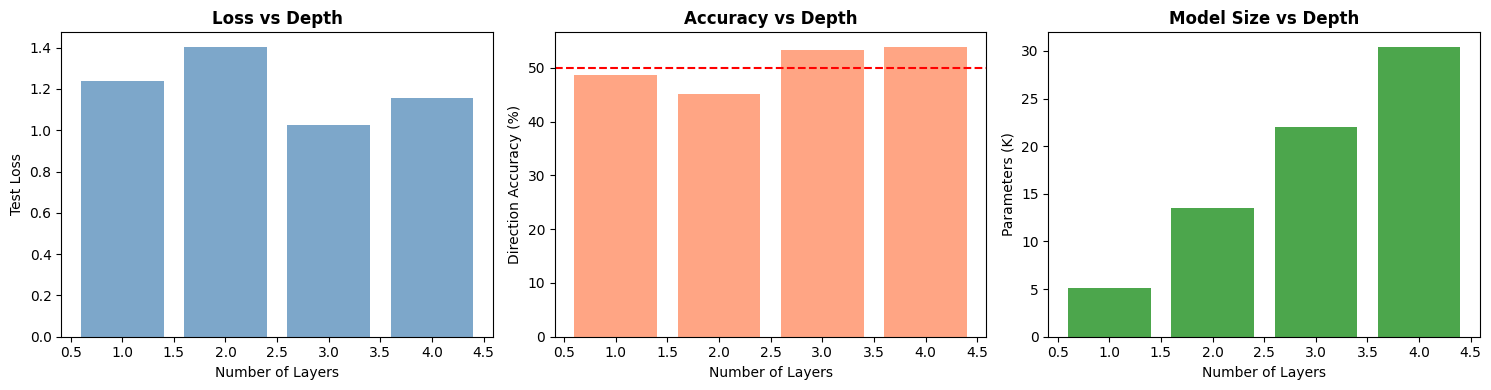

In [3]:
# ============================================================
# COMPARE DIFFERENT DEPTHS
# ============================================================

print("COMPARING LSTM DEPTHS")
print("="*60)

class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layer_norm(out[:, -1, :])
        return self.fc(out)

depths = [1, 2, 3, 4]
results = {}

for depth in depths:
    model = StackedLSTM(input_size=5, hidden_size=32, num_layers=depth)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    for epoch in range(50):
        model.train()
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_b), y_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy().flatten()
        actuals = y_test.numpy().flatten()
        test_loss = criterion(model(X_test), y_test).item()
        dir_acc = np.mean(np.sign(preds) == np.sign(actuals))
    
    n_params = sum(p.numel() for p in model.parameters())
    results[depth] = {'loss': test_loss, 'dir_acc': dir_acc, 'params': n_params}
    
    print(f"  Depth {depth}: Loss={test_loss:.6f}, Acc={dir_acc*100:.1f}%, Params={n_params:,}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(depths, [r['loss'] for r in results.values()], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Number of Layers')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Loss vs Depth', fontweight='bold')

axes[1].bar(depths, [r['dir_acc']*100 for r in results.values()], color='coral', alpha=0.7)
axes[1].axhline(50, color='red', linestyle='--')
axes[1].set_xlabel('Number of Layers')
axes[1].set_ylabel('Direction Accuracy (%)')
axes[1].set_title('Accuracy vs Depth', fontweight='bold')

axes[2].bar(depths, [r['params']/1000 for r in results.values()], color='green', alpha=0.7)
axes[2].set_xlabel('Number of Layers')
axes[2].set_ylabel('Parameters (K)')
axes[2].set_title('Model Size vs Depth', fontweight='bold')

plt.tight_layout()
plt.show()

## Part 2: Bidirectional RNNs

⚠️ **WARNING for Finance**: Bidirectional RNNs use future information!

```
Forward:  x₁ → x₂ → x₃ → ... → xₜ
Backward: x₁ ← x₂ ← x₃ ← ... ← xₜ
```

This creates **look-ahead bias** - only use for non-predictive tasks!

In [4]:
# ============================================================
# BIDIRECTIONAL LSTM (DEMONSTRATION ONLY)
# ============================================================

print("BIDIRECTIONAL LSTM (LOOK-AHEAD BIAS WARNING!)")
print("="*60)

class BiLSTM(nn.Module):
    """⚠️ DO NOT USE FOR PREDICTION - causes look-ahead bias!"""
    
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True  # ⚠️ DANGER!
        )
        
        # Note: hidden_size * 2 because bidirectional
        self.fc = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Train bidirectional (will have unrealistically good results!)
bi_model = BiLSTM(input_size=5, hidden_size=32, num_layers=2)
optimizer = optim.Adam(bi_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(50):
    bi_model.train()
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(bi_model(X_b), y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bi_model.parameters(), 1.0)
        optimizer.step()

# Compare
uni_model = StackedLSTM(input_size=5, hidden_size=32, num_layers=2)
for epoch in range(50):
    uni_model.train()
    for X_b, y_b in train_loader:
        optimizer = optim.Adam(uni_model.parameters(), lr=0.001)
        optimizer.zero_grad()
        loss = criterion(uni_model(X_b), y_b)
        loss.backward()
        optimizer.step()

# Evaluate
bi_model.eval()
uni_model.eval()

with torch.no_grad():
    bi_preds = bi_model(X_test).numpy().flatten()
    uni_preds = uni_model(X_test).numpy().flatten()
    actuals = y_test.numpy().flatten()

bi_acc = np.mean(np.sign(bi_preds) == np.sign(actuals))
uni_acc = np.mean(np.sign(uni_preds) == np.sign(actuals))

print(f"\nUnidirectional LSTM: {uni_acc*100:.1f}% accuracy")
print(f"Bidirectional LSTM:  {bi_acc*100:.1f}% accuracy")
print(f"\n⚠️ BiLSTM may look better but it's CHEATING!")
print("   It uses future data that wouldn't be available in live trading.")

BIDIRECTIONAL LSTM (LOOK-AHEAD BIAS WARNING!)

Unidirectional LSTM: 41.5% accuracy
Bidirectional LSTM:  42.5% accuracy

⚠️ BiLSTM may look better but it's CHEATING!
   It uses future data that wouldn't be available in live trading.


## Part 3: When to Use Bidirectional

**Valid uses in finance:**
- Anomaly detection (after the fact)
- Pattern classification (known outcomes)
- NLP sentiment analysis

**NEVER use for:**
- Price/return prediction
- Trading signals
- Any real-time decision making

In [5]:
# ============================================================
# VALID USE CASE: ANOMALY DETECTION (AFTER THE FACT)
# ============================================================

print("VALID USE CASE: ANOMALY DETECTION")
print("="*60)

# For anomaly detection, we're looking at historical data
# where we already know the outcomes - BiLSTM is valid here

print("""
Scenario: Analyzing past market crashes to identify patterns

✅ BiLSTM is valid because:
   - We're analyzing HISTORICAL data
   - We already know the outcomes
   - Not making real-time predictions
   
The model can see before AND after the anomaly to classify it.
""")

VALID USE CASE: ANOMALY DETECTION

Scenario: Analyzing past market crashes to identify patterns

✅ BiLSTM is valid because:
   - We're analyzing HISTORICAL data
   - We already know the outcomes
   - Not making real-time predictions

The model can see before AND after the anomaly to classify it.



In [6]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║        DAY 5 COMPLETE: STACKED & BIDIRECTIONAL                   ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Stacked LSTMs for deeper representations                     ║
║  ✓ LayerNorm for training stability                             ║
║  ✓ Bidirectional RNNs - DANGER for predictions!                 ║
║  ✓ Valid use cases for BiLSTM                                   ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 6 - Attention Mechanisms
""")


╔══════════════════════════════════════════════════════════════════╗
║        DAY 5 COMPLETE: STACKED & BIDIRECTIONAL                   ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Stacked LSTMs for deeper representations                     ║
║  ✓ LayerNorm for training stability                             ║
║  ✓ Bidirectional RNNs - DANGER for predictions!                 ║
║  ✓ Valid use cases for BiLSTM                                   ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 6 - Attention Mechanisms

